                                        mean         stddev       min  \
case_id                         1.286077e+06  718946.592285       0.0   
MONTH                           2.019363e+05      44.735975  201901.0   
WEEK_NUM                        4.076904e+01      23.797981       0.0   
target                          3.143728e-02       0.174496       0.0   
amtinstpaidbefduel24m_4187115A  4.614726e+04   58388.391819       0.0   
annuity_780A                    4.039207e+03    3006.607629      80.8   
annuitynextmonth_57A            1.435771e+03    2807.018517       0.0   
avginstallast24m_3658937A       4.844032e+03    5064.412428       0.0   
credamount_770A                 4.987016e+04   44183.694010    2000.0   
currdebt_22A                    1.968237e+04   50835.226097       0.0   
currdebtcredtyperange_828A      1.099633e+04   36790.275018       0.0   
disbursedcredamount_1113A       4.607475e+04   42505.443332       0.0   
downpmt_116A                    5.523810e+02    410

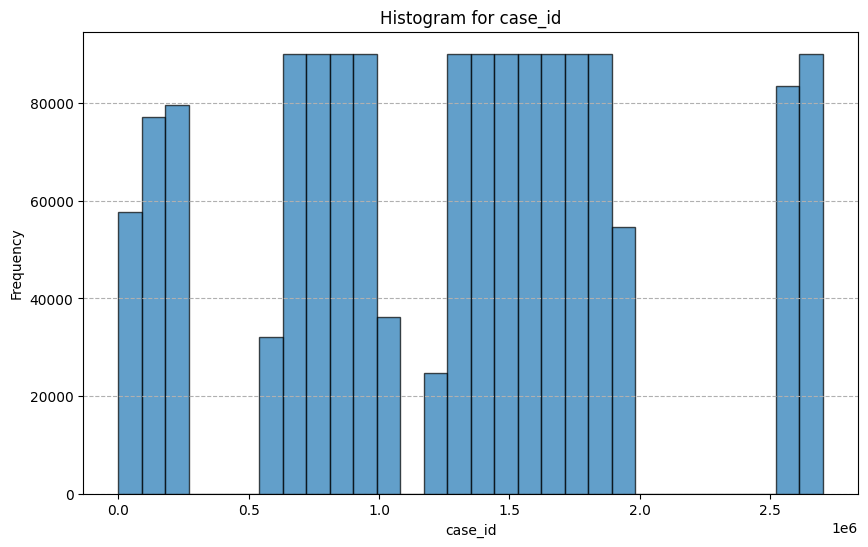

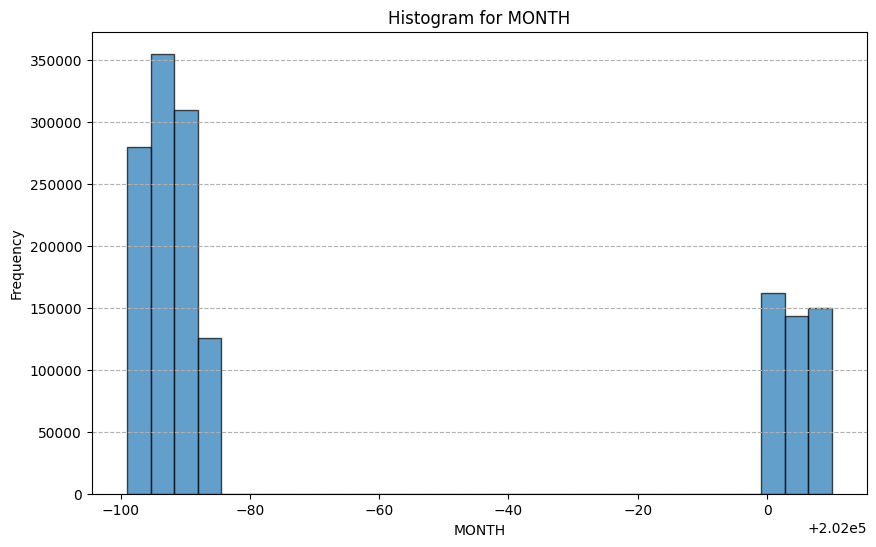

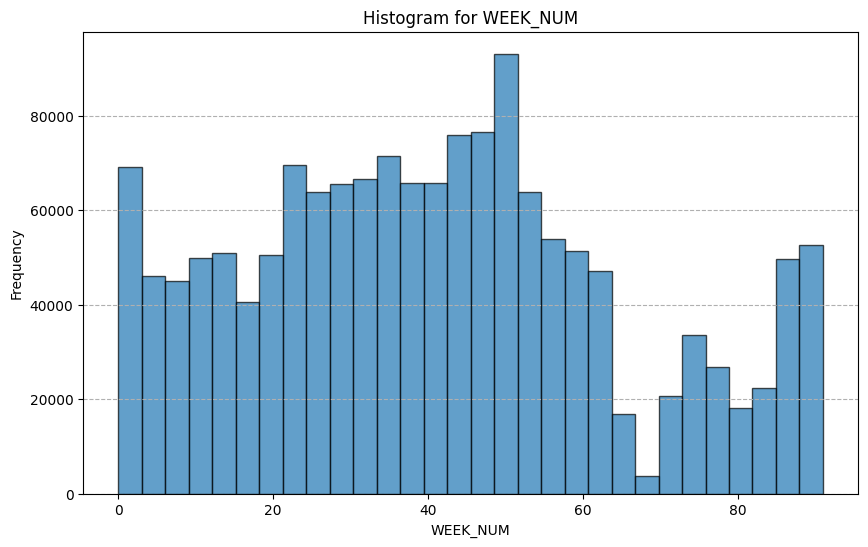

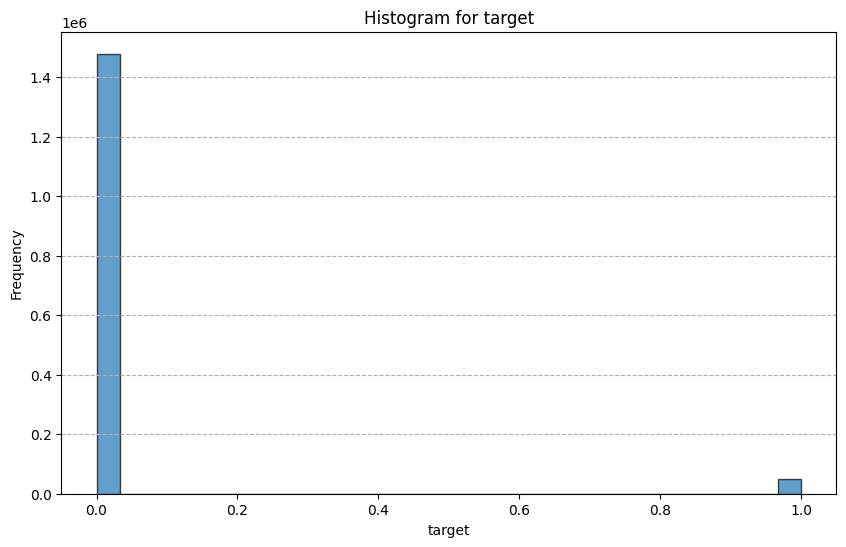

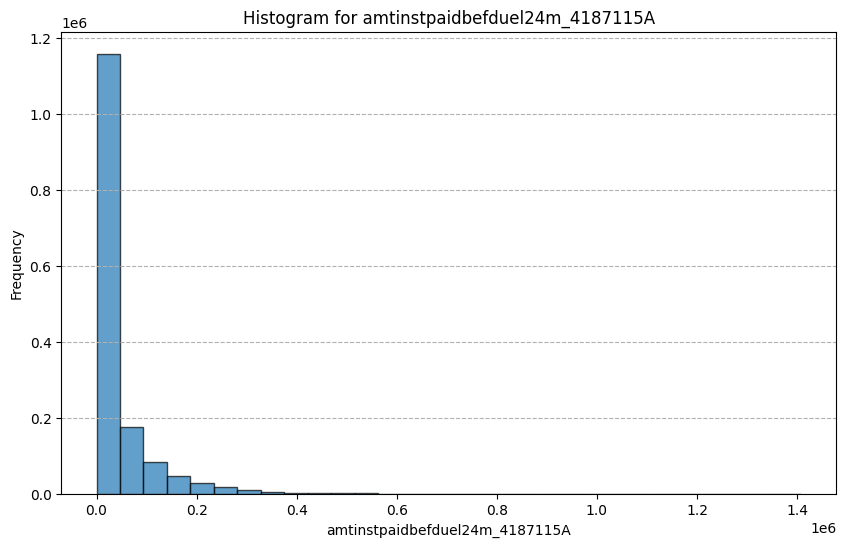

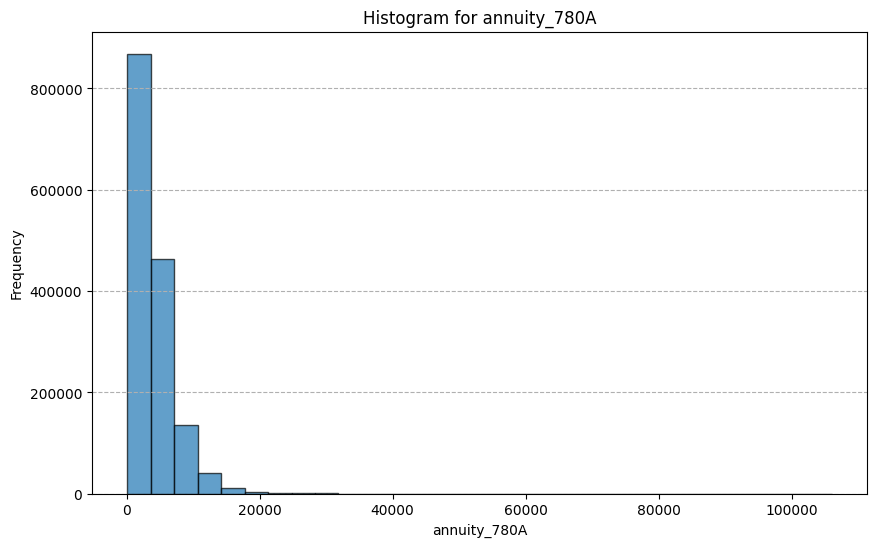

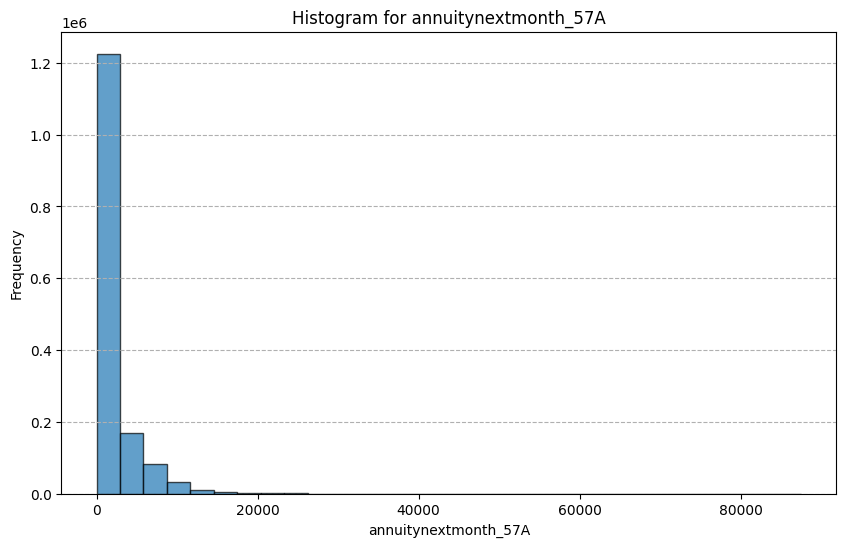

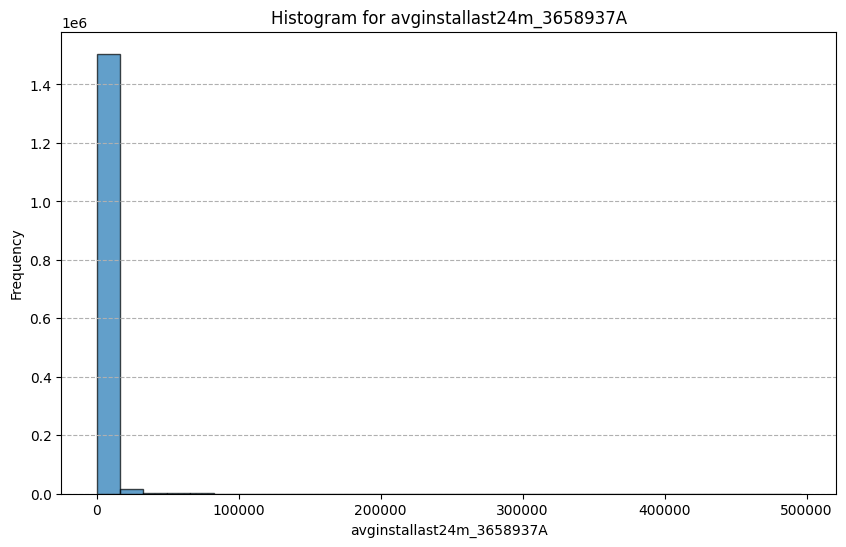

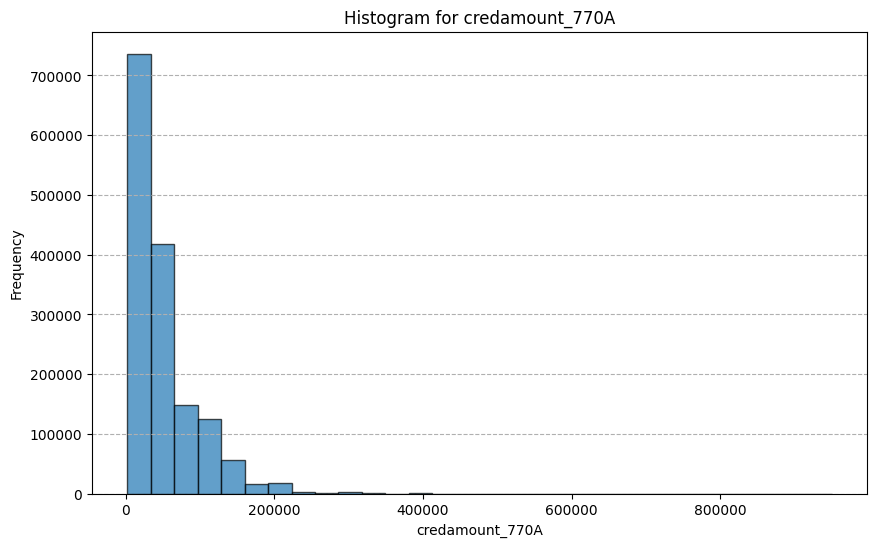

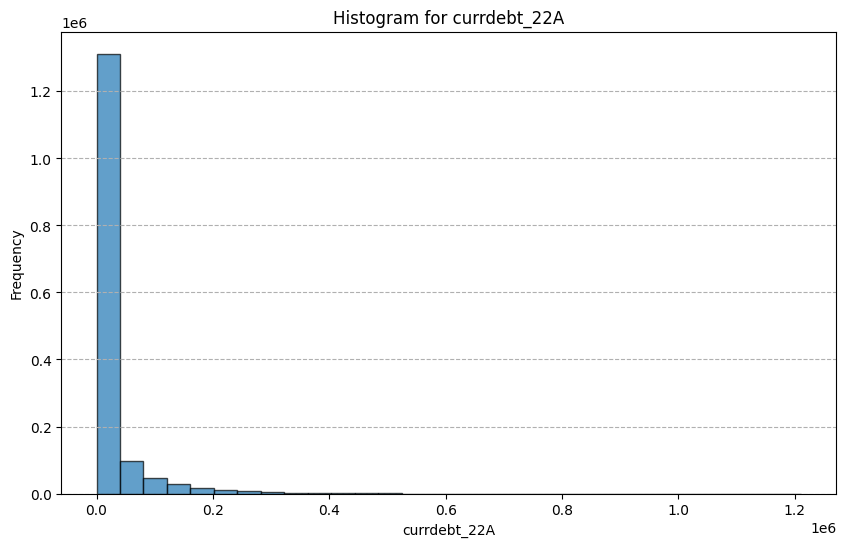

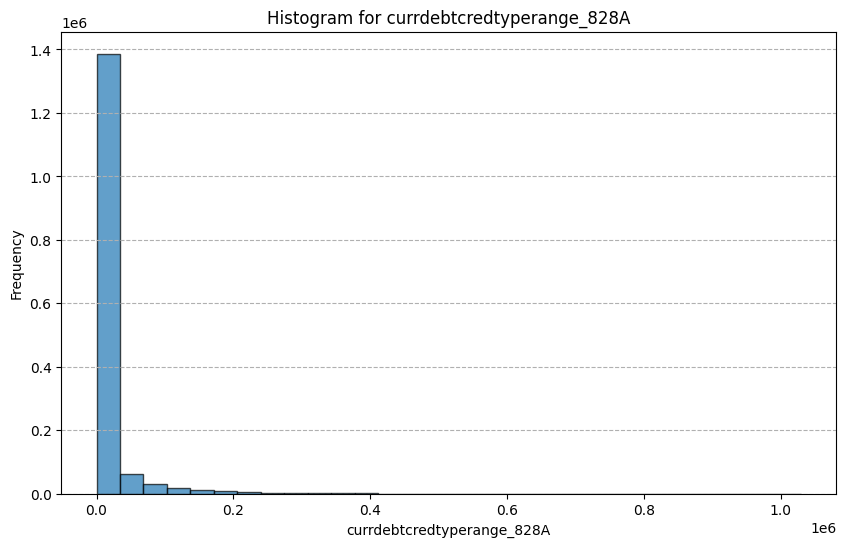

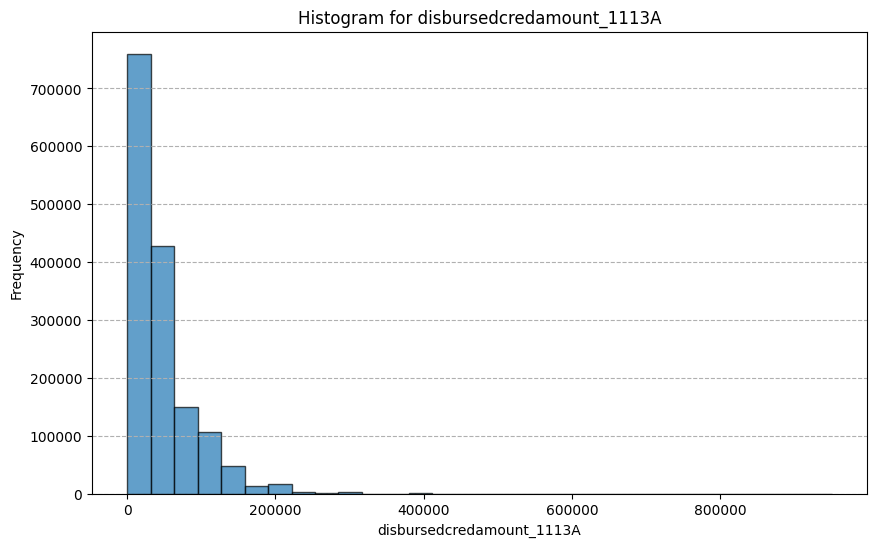

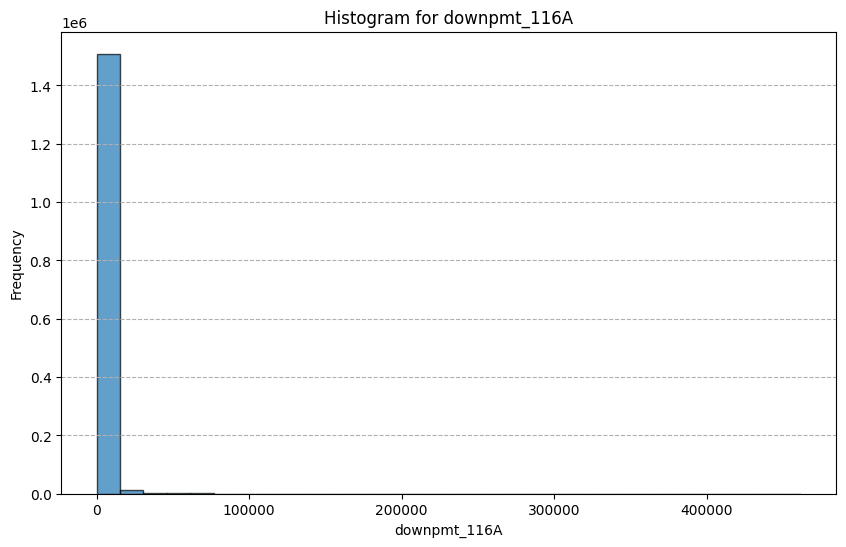

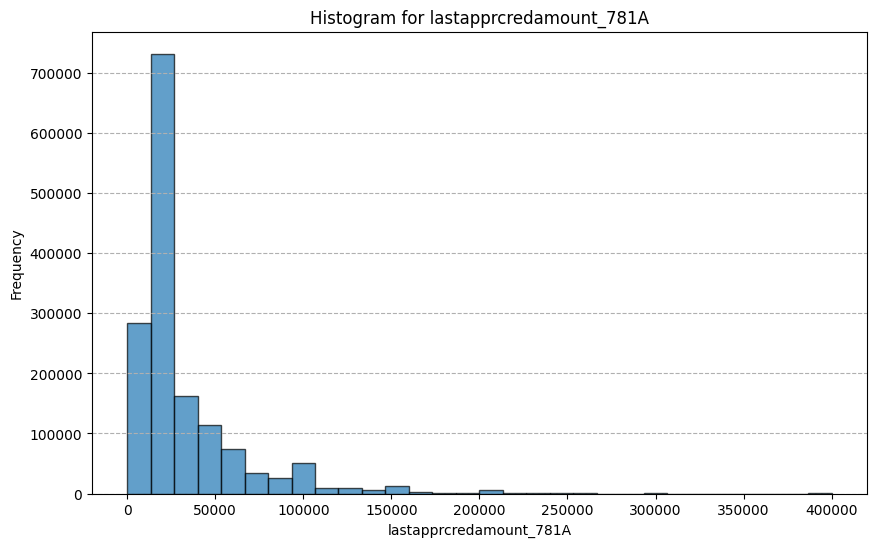

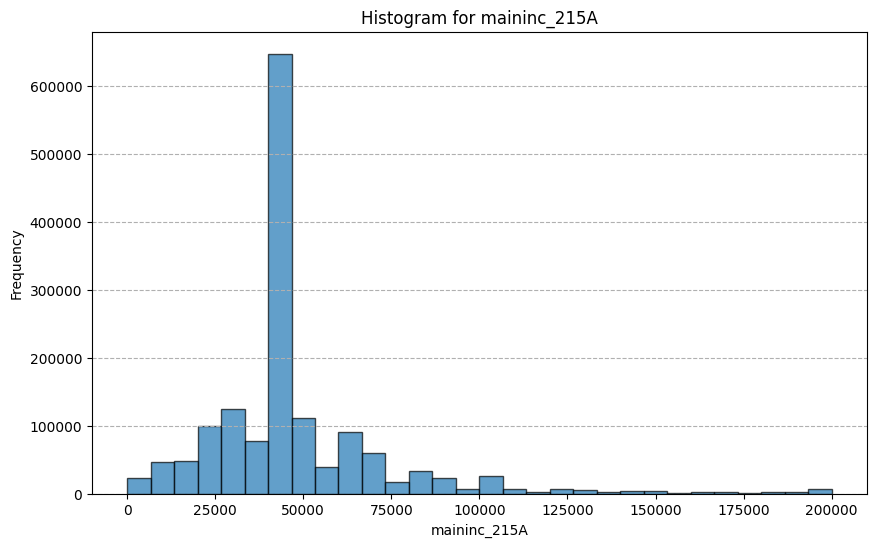

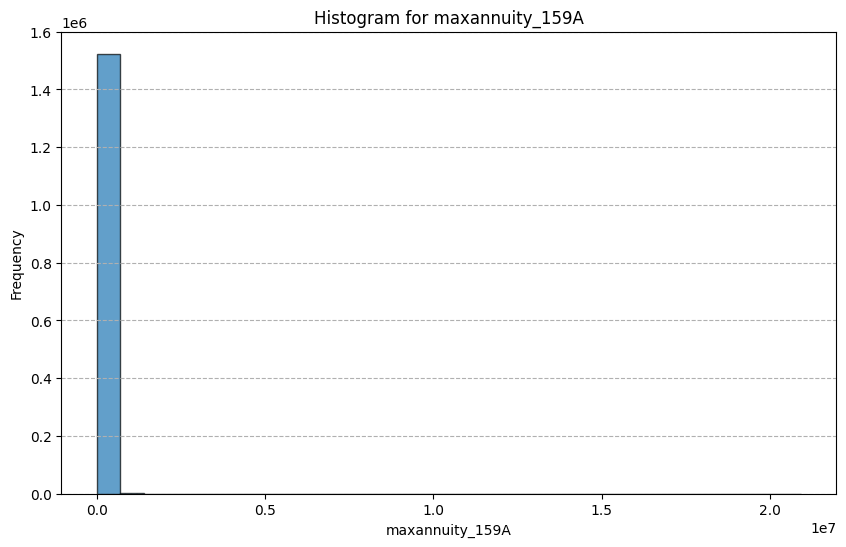

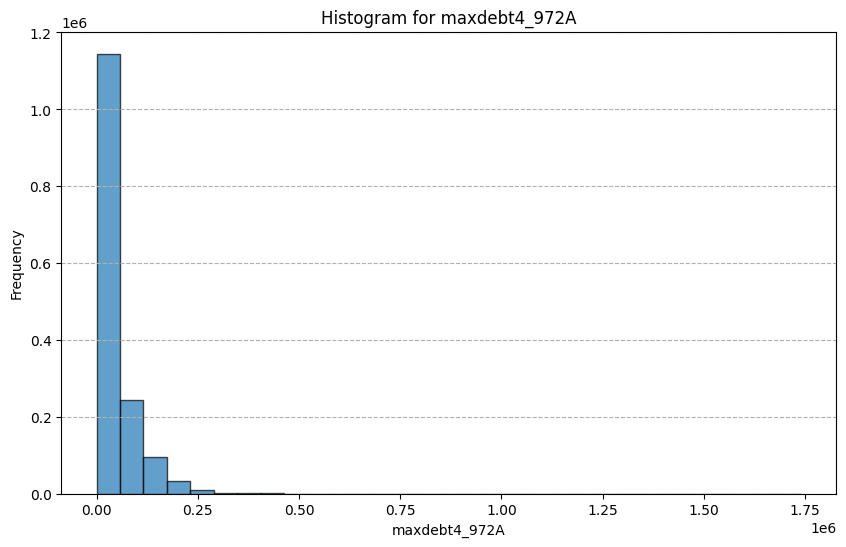

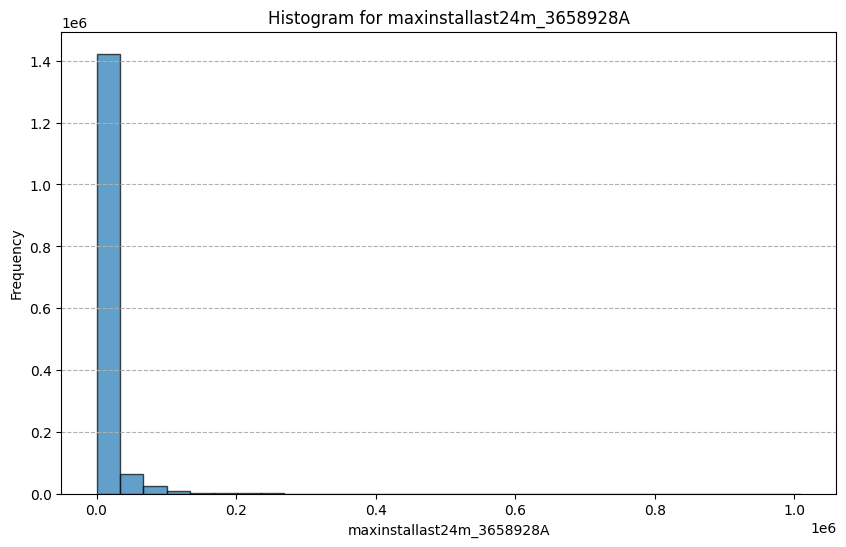

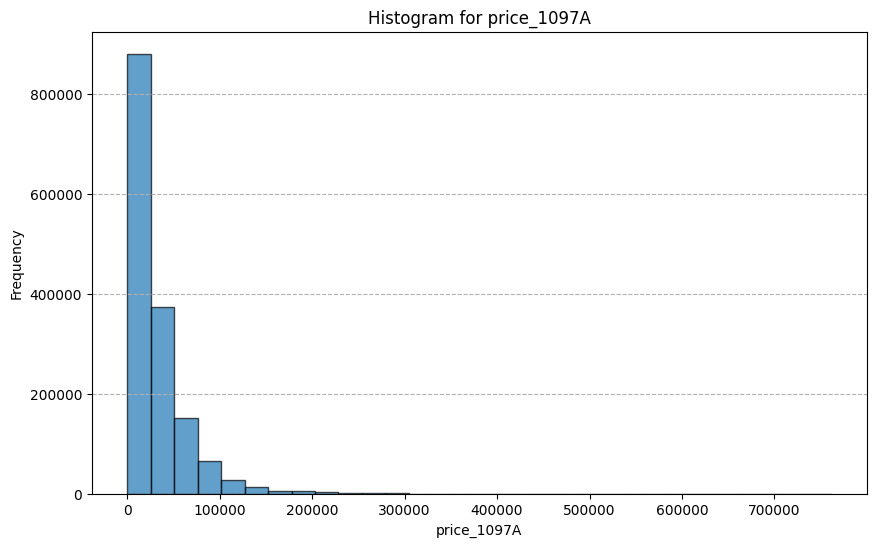

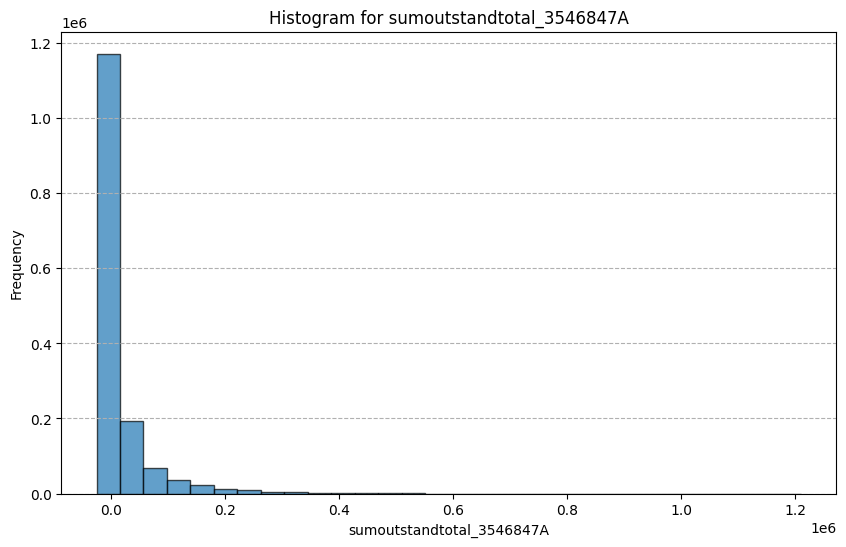

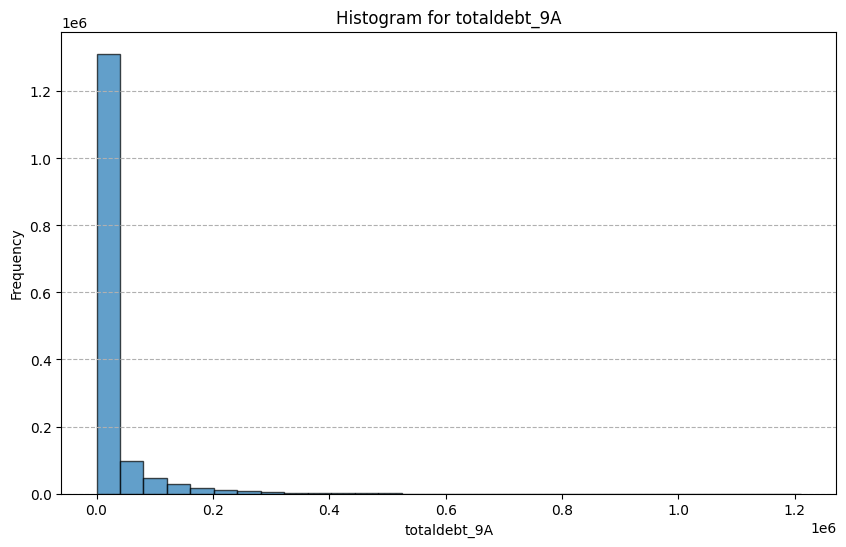

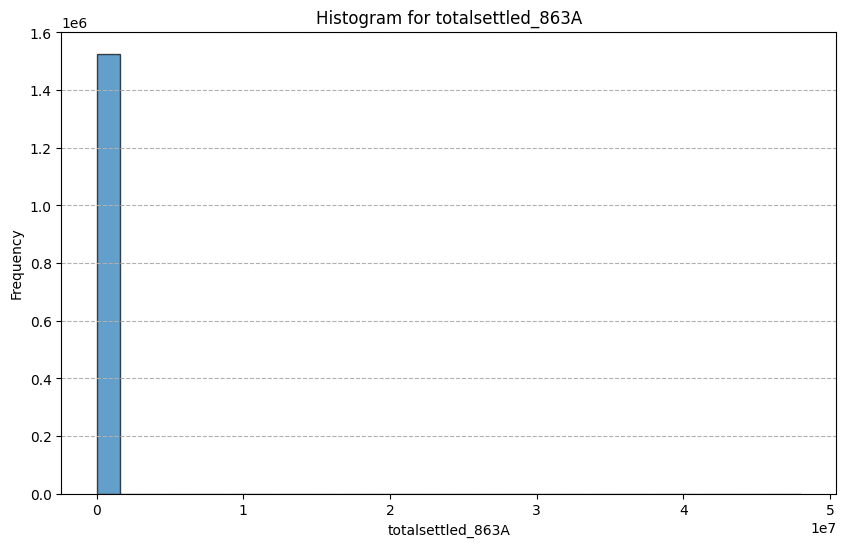

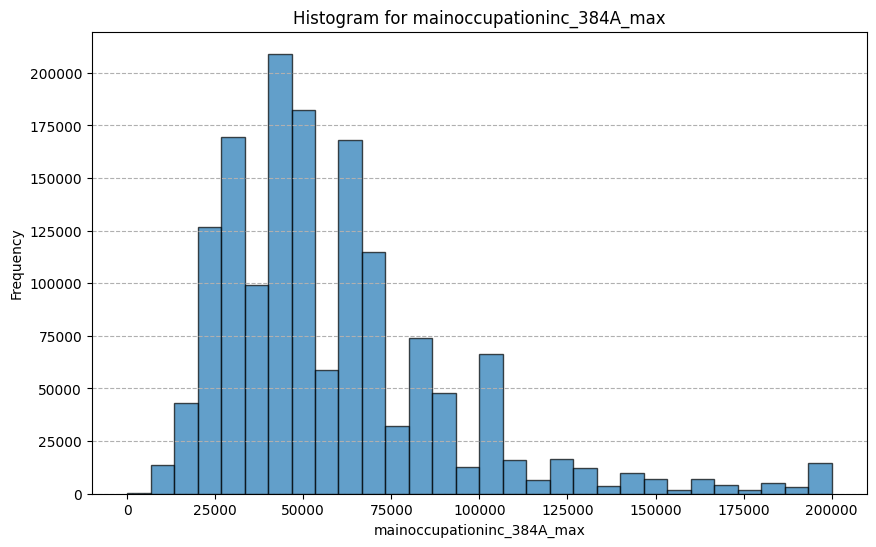

Column: case_id
  Mean: 1286076.571738679
  Median: 1348814.0
  Standard Deviation: 718946.5922850738
  Min: 0.0
  Max: 2703454.0

Column: MONTH
  Mean: 201936.28798245057
  Median: 201910.0
  Standard Deviation: 44.73597450346654
  Min: 201901.0
  Max: 202010.0

Column: WEEK_NUM
  Mean: 40.76903617638254
  Median: 40.0
  Standard Deviation: 23.79798129273298
  Min: 0.0
  Max: 91.0

Column: target
  Mean: 0.03143727577671242
  Median: 0.0
  Standard Deviation: 0.1744963994279167
  Min: 0.0
  Max: 1.0

Column: amtinstpaidbefduel24m_4187115A
  Mean: 46147.262146447974
  Median: 29265.201
  Standard Deviation: 58388.39181852495
  Min: 0.0
  Max: 1408010.2

Column: annuity_780A
  Mean: 4039.207272097294
  Median: 3119.8
  Standard Deviation: 3006.6076291543955
  Min: 80.8
  Max: 106007.0

Column: annuitynextmonth_57A
  Mean: 1435.7712530804552
  Median: 0.0
  Standard Deviation: 2807.018516566163
  Min: 0.0
  Max: 87500.0

Column: avginstallast24m_3658937A
  Mean: 4844.032257792998
  Media

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, min, max, expr, count, when
import matplotlib.pyplot as plt
import pandas as pd

# Initialize a Spark session
spark = SparkSession.builder.appName("BigDataAnalysis").getOrCreate()

# Load the dataset
file_path = "sampled_data.csv"  # Replace with your file path
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Data Cleaning

# 1. Drop columns with more than 50% missing values
threshold = 0.5 * df.count()
columns_to_keep = [c for c in df.columns if df.filter(col(c).isNotNull()).count() > threshold]
df = df.select(columns_to_keep)

# 2. Fill missing values for numerical columns with the median instead of mean
numerical_columns = [c for c, dtype in df.dtypes if dtype in ('int', 'double')]
for col_name in numerical_columns:
    median_value = df.approxQuantile(col_name, [0.5], 0.01)[0]
    df = df.fillna({col_name: median_value})

# 3. Fill missing values for categorical columns with 'Unknown'
categorical_columns = [c for c, dtype in df.dtypes if dtype == 'string']
for col_name in categorical_columns:
    df = df.na.fill(value="Unknown", subset=[col_name])

# 4. Remove duplicate rows
df = df.dropDuplicates()

# 5. Cap outliers for numerical columns (using the 1st and 99th percentiles)
for col_name in numerical_columns:
    lower_bound, upper_bound = df.approxQuantile(col_name, [0.01, 0.99], 0.01)
    df = df.withColumn(col_name, when(col(col_name) < lower_bound, lower_bound)
                                     .when(col(col_name) > upper_bound, upper_bound)
                                     .otherwise(col(col_name)))

# Calculate Descriptive Statistics for Numerical Columns
stats_summary = {}
for col_name in numerical_columns:
    # Calculate mean, standard deviation, min, and max
    mean_value = df.select(mean(col(col_name))).collect()[0][0]
    stddev_value = df.select(stddev(col(col_name))).collect()[0][0]
    min_value = df.select(min(col(col_name))).collect()[0][0]
    max_value = df.select(max(col(col_name))).collect()[0][0]
    
    # Calculate median using approxQuantile
    median_value = df.approxQuantile(col_name, [0.5], 0.01)[0]

    # Store statistics in dictionary
    stats_summary[col_name] = {
        "mean": mean_value,
        "stddev": stddev_value,
        "min": min_value,
        "max": max_value,
        "median": median_value
    }

# Convert the summary dictionary to a Pandas DataFrame for easier visualization
stats_df = pd.DataFrame(stats_summary).transpose()
print(stats_df)

# Plot histograms for numerical columns
for col_name in numerical_columns:
    # Convert the column to Pandas for plotting
    pandas_df = df.select(col_name).toPandas().dropna()
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(pandas_df[col_name], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Histogram for {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--')
    plt.show()

# Display the calculated statistics for each numerical column
for col_name, stats in stats_summary.items():
    print(f"Column: {col_name}")
    print(f"  Mean: {stats['mean']}")
    print(f"  Median: {stats['median']}")
    print(f"  Standard Deviation: {stats['stddev']}")
    print(f"  Min: {stats['min']}")
    print(f"  Max: {stats['max']}\n")


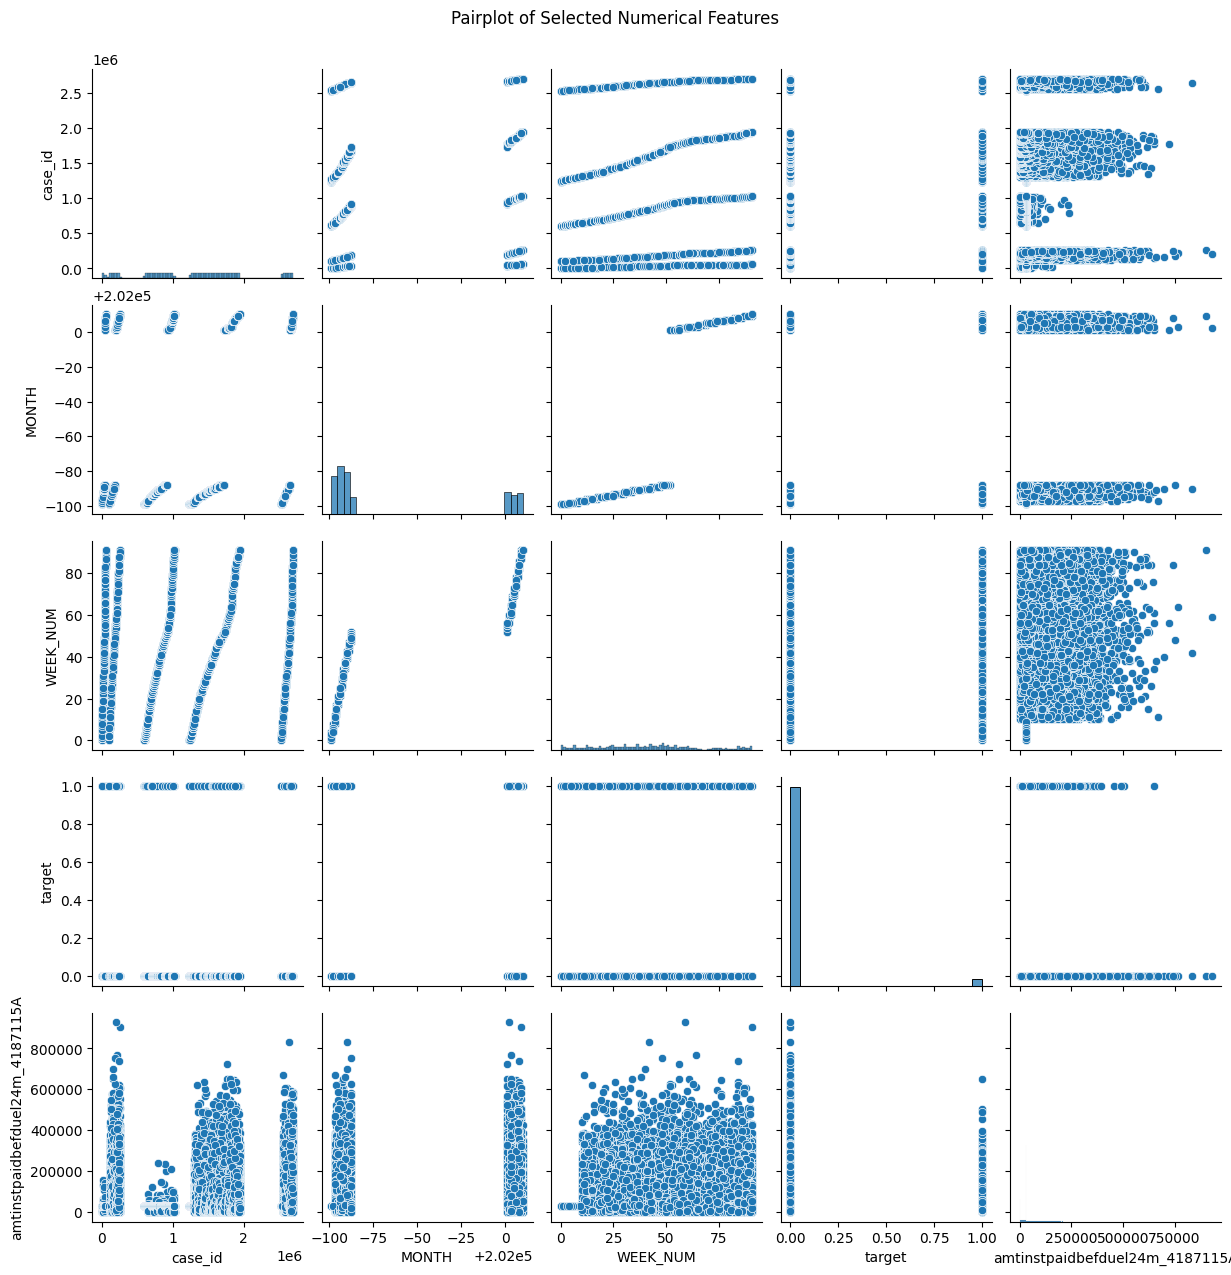

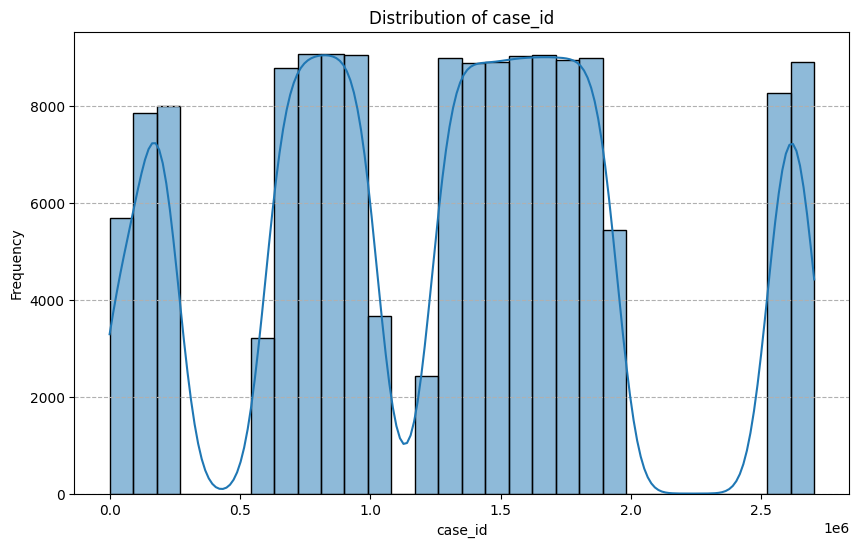

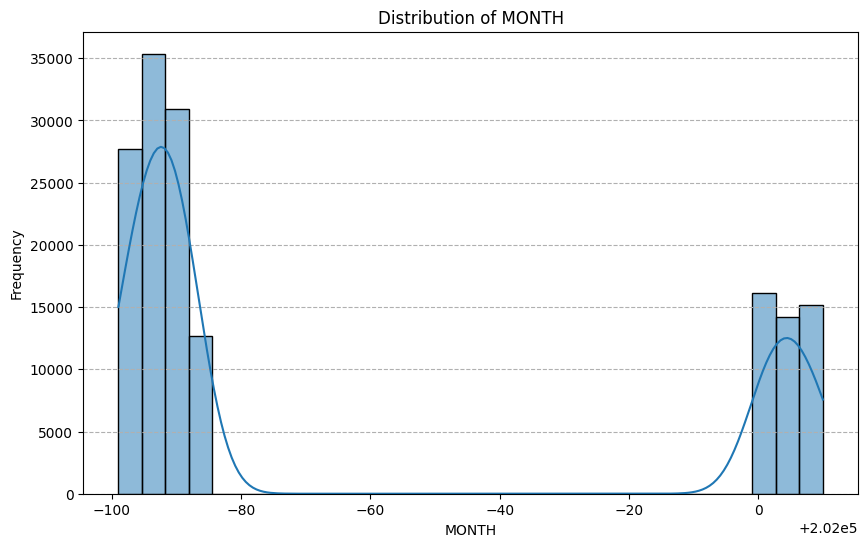

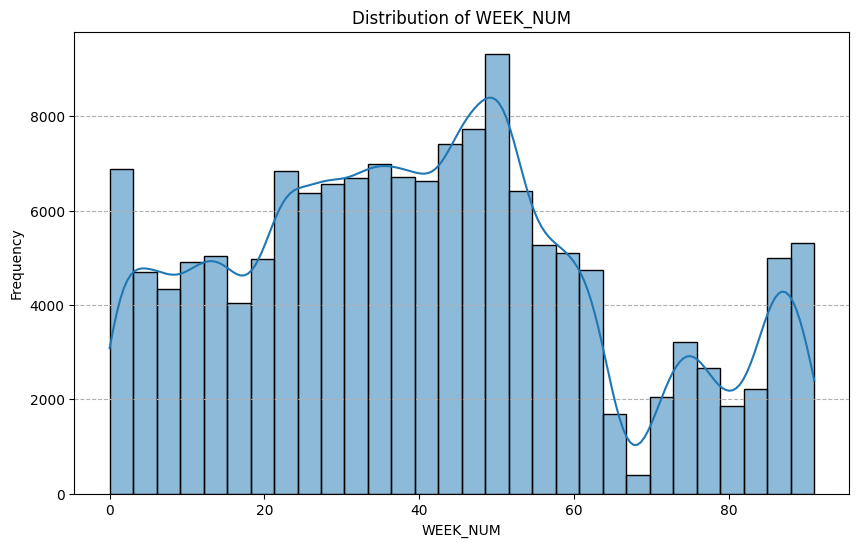

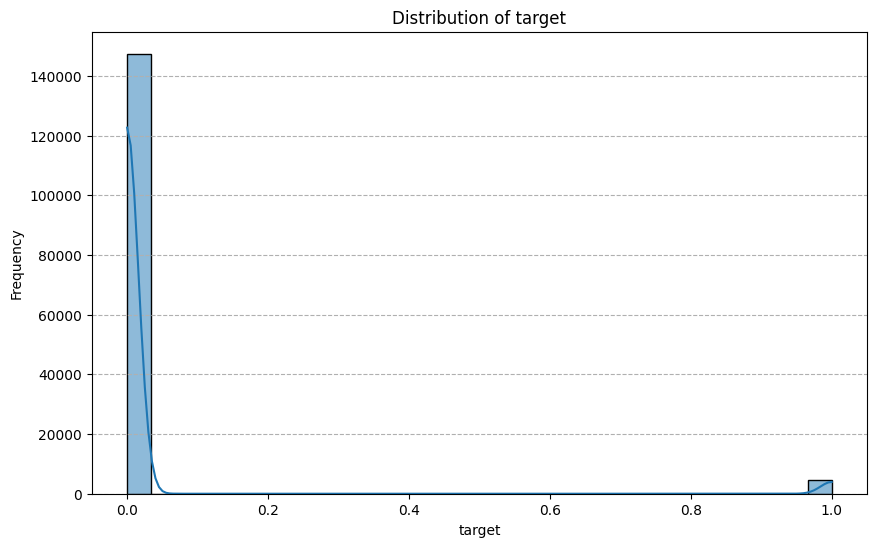

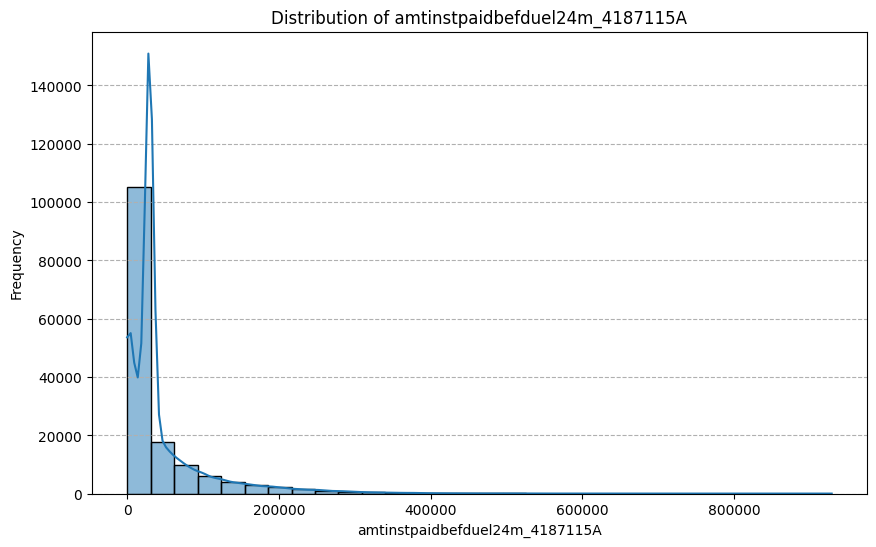

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pandas, x=col, palette='viridis')


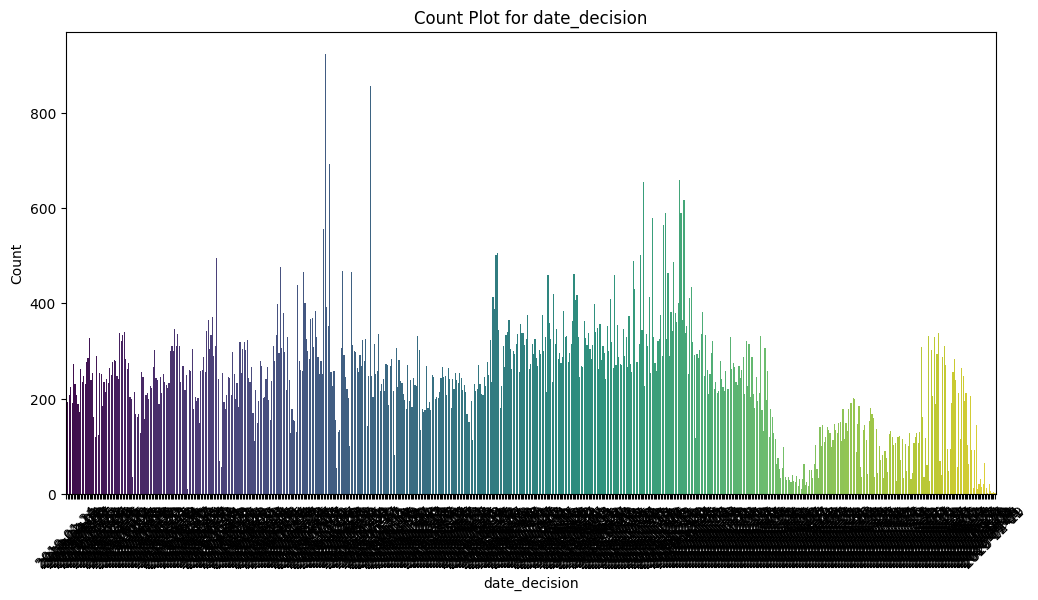

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pandas, x=col, palette='viridis')


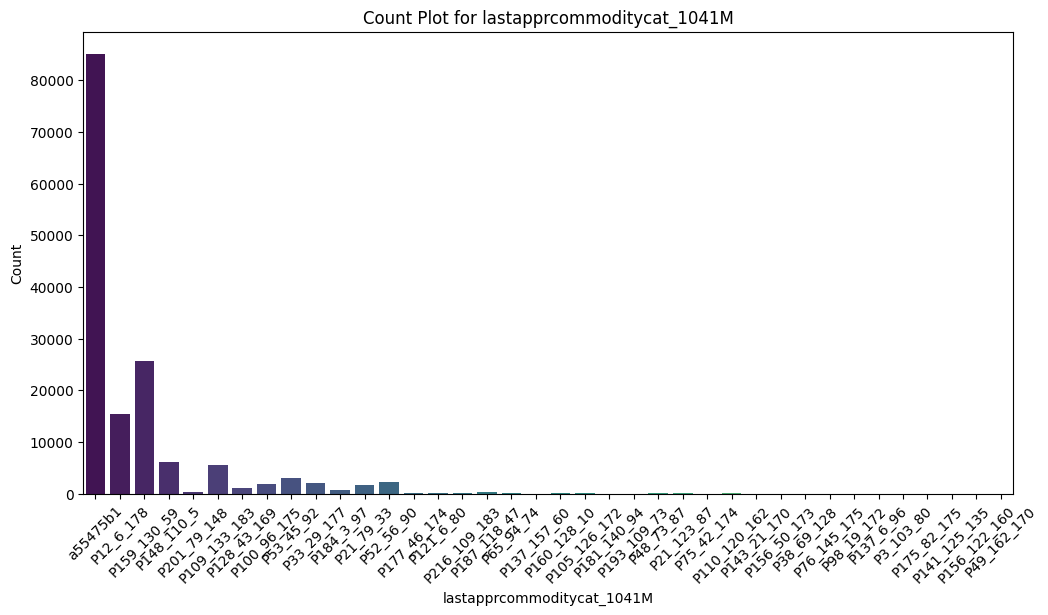

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pandas, x=col, palette='viridis')


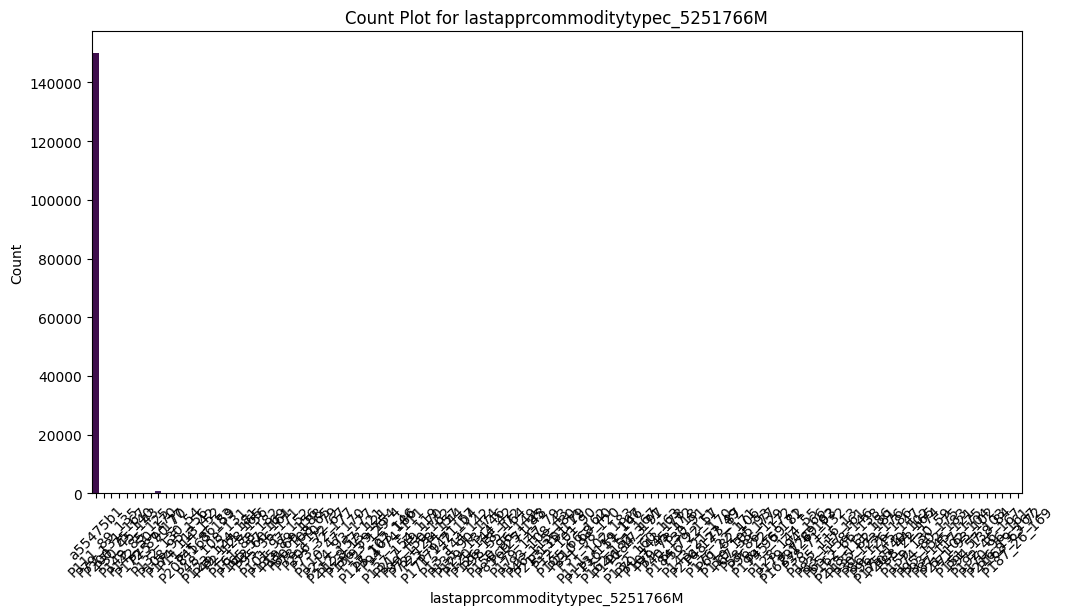

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x=col, palette='Set2')


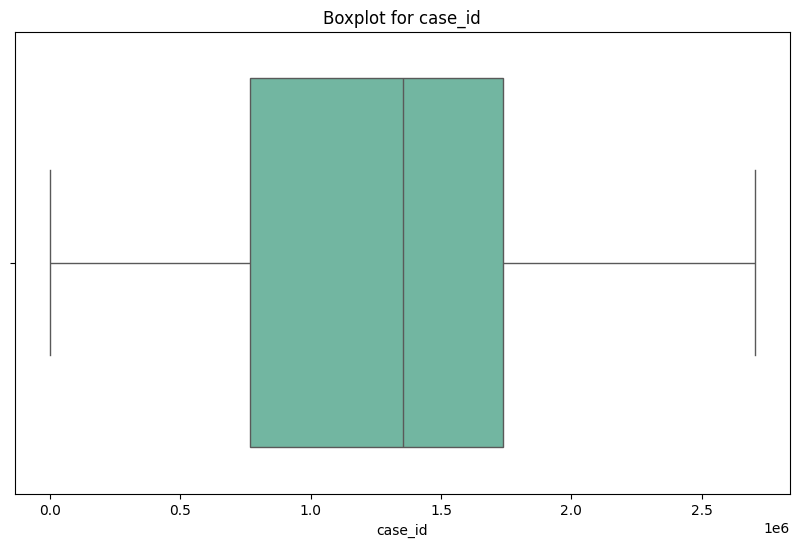

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x=col, palette='Set2')


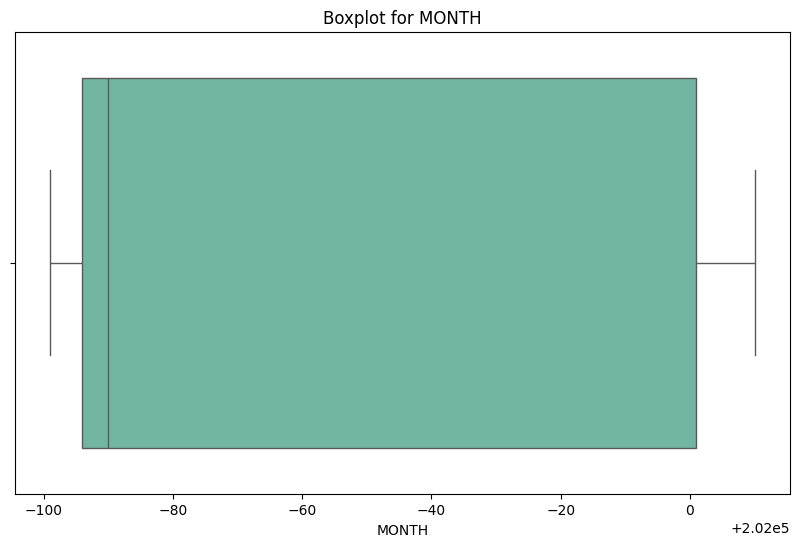

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x=col, palette='Set2')


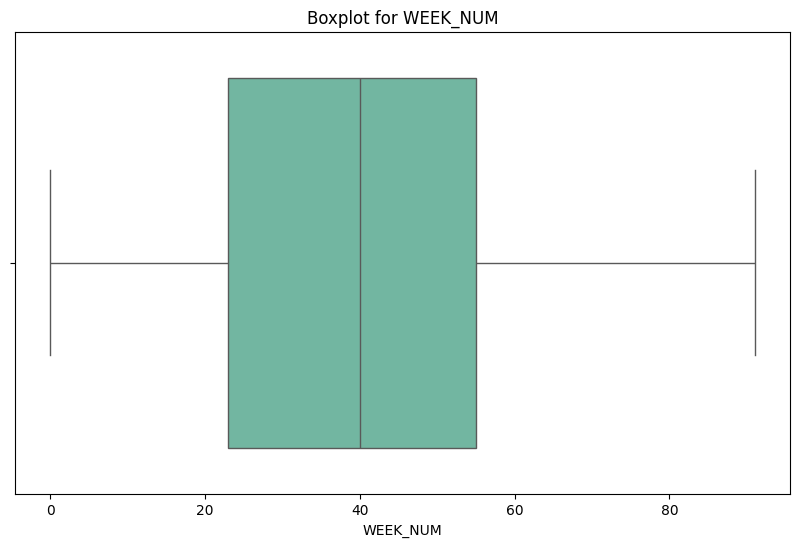

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x=col, palette='Set2')


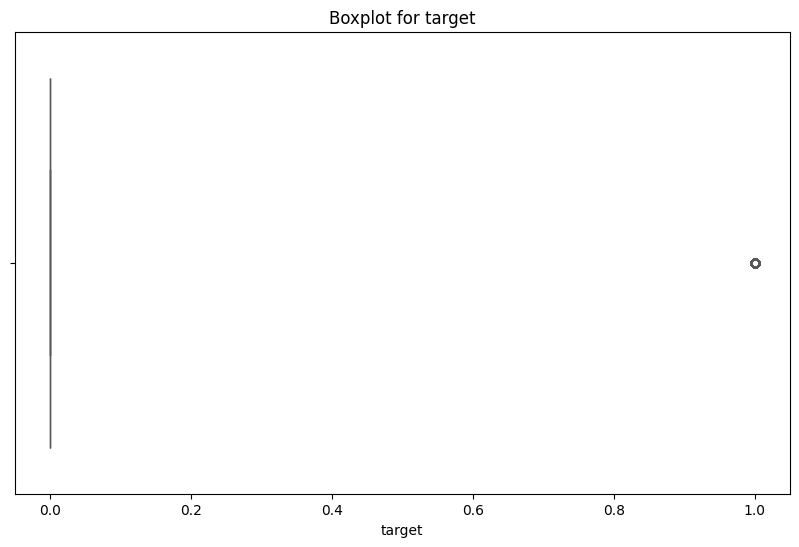

C:\Users\manav\AppData\Local\Temp\ipykernel_15584\2072504590.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pandas, x=col, palette='Set2')


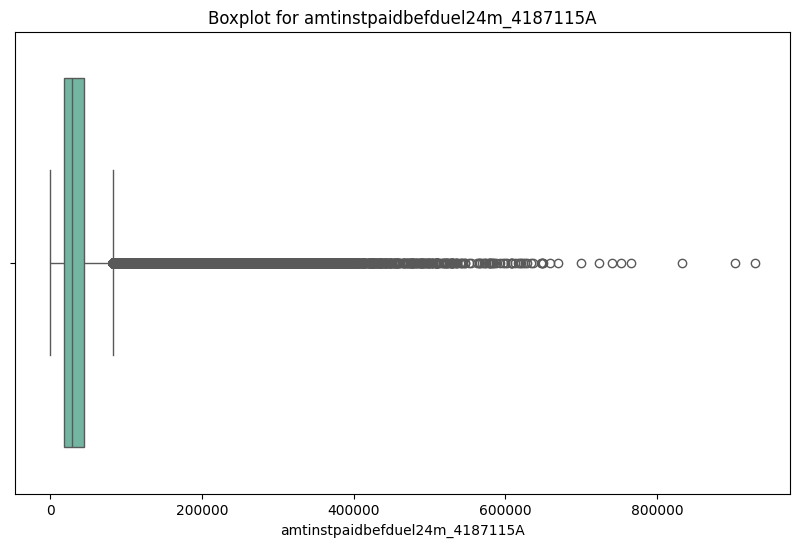

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample the cleaned Spark DataFrame to reduce memory usage for visualization
df_sample = df.sample(fraction=0.1)  # Adjust fraction as needed
df_pandas = df_sample.toPandas()

# Remove datetime columns to avoid errors in correlation
for col in df_pandas.select_dtypes(include=['datetime64', 'datetime']).columns:
    df_pandas.drop(columns=[col], inplace=True)

# Visualization Code

# # 1. Correlation Heatmap
# plt.figure(figsize=(14, 10))
# sns.heatmap(df_pandas.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title("Correlation Heatmap of Numerical Features")
# plt.show()

# 2. Pairplot for Selected Columns
selected_columns = df_pandas.select_dtypes(include=['float64', 'int64']).columns[:5]  # Selecting a few numerical columns
sns.pairplot(df_pandas[selected_columns])
plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
plt.show()

# 3. Distribution Plots for Key Numerical Features
for col in selected_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_pandas[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--')
    plt.show()

# 4. Count Plot for Categorical Features
categorical_columns = df_pandas.select_dtypes(include=['object']).columns[:3]  # Selecting a few categorical columns
for col in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_pandas, x=col, palette='viridis')
    plt.title(f"Count Plot for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# 5. Boxplot to Visualize Outliers in Numerical Columns
for col in selected_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_pandas, x=col, palette='Set2')
    plt.title(f"Boxplot for {col}")
    plt.xlabel(col)
    plt.show()
